In [1]:
import torch
import torchvision

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, 'util')
import vcpi_util

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(device)

2.2.1
cpu


In [3]:
BATCH_SIZE = 64
EPOCKS = 20
IMG_SIZE = 32
EPOCHS = 1000

PATH_TRAINING_SET = "data/train/Final_Training/Images"
PATH_TEST_SET = "data/test"

In [47]:
def train(model, train_loader, test_loader, epochs, loss_fn, optimizer):

    history = {}
    history['accuracy'] = []
    history['test_acc'] = []
    history['loss'] = []
    best_t_accuracy = -np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):
            
            # send data to device, hopefully the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass, compute the output of the model for the current batch
            outputs = model(inputs)


            _, predicted = torch.max(outputs, 1)

            #compute the loss between the model's outputs and the labels, or targets.
            loss = loss_fn(outputs, targets)
            
            # zero the parameter gradients
            # this function must be called before calling "backward" on the losses, otherwise the gradients get accumulated with previous batches.
            optimizer.zero_grad()

            # perform backpropagation
            loss.backward()
            #update the model's parameters
            optimizer.step()

            running_loss += loss.detach()
            correct += (predicted == targets).sum()

        model.eval()
        t_correct = 0
        with torch.no_grad():
            for i,t in test_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)
                _,p = torch.max(o,1)

                t_correct += (p == t).sum()

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        t_accuracy = 100 * t_correct / len(test_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.4f}; Accuracy: {accuracy:0.4f}; Test_Acc: {t_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['test_acc'].append(t_accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())

    print('Finished Training')
           
    return(history)

def train2(model, train_loader, val_loader, epochs, loss_fn, optimizer,
           scheduler, early_stopper, save_prefix = 'model'):

    history = {}
    history['accuracy'] = []
    history['val_acc'] = []
    history['val_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):
            
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        model.eval()
        v_correct = 0
        val_loss = 0.0
        with torch.no_grad():
            for i,t in val_loader:
                i = i.to(device)
                t = t.to(device)
                o = model(i)
                _,p = torch.max(o,1)
                
                #with torch.no_grad():
                val_loss += loss_fn(o, t)

                v_correct += (p == t).sum()

        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        v_accuracy = 100 * v_correct / len(val_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Accuracy: {accuracy:0.4f}; Val Loss: {val_loss:0.6f}; Val Acc: {v_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['val_acc'].append(v_accuracy.cpu().numpy())
        history['val_loss'].append(val_loss.cpu().detach().numpy())
        history['loss'].append(epoch_loss.cpu().detach().numpy())
 
        ###### Saving ######
        if val_loss < best_val_loss :
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model':model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'history' : history
                },
                f'models/{save_prefix}.pt')

        if early_stopper(val_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')

    return(history)


def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


class Conv(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)


        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(1200, num_classes)
        

    def forward(self, x):    
        
        # input = (bs, 3, 32, 32)
        x = self.conv1(x) # -> (bs, 16, 30, 30)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x) # -> (bs, 32, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool1(x) # -> (bs, 32, 14, 14)
        
        x = self.conv3(x) # -> (bs, 48, 12, 12)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x) # -> (bs, 48, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool2(x) # -> (bs, 48, 5, 5)
        
        x = torch.flatten(x,1) # -> (bs, 48 * 5 * 5 = 1200)
        x = self.fc1(x)        # -> (bs, num_classes)

        return(x)


class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):

        self.patience = patience 
        self.min_delta = min_delta

        self.min_delta
        self.min_val_loss = float('inf')

    def __call__(self, val_loss):

        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False
    


def build_confusion_matrix(model, dataset):

    preds = []
    ground_truth = []

    for images, targets in dataset:

        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds, len(test_set.classes)) 

def build_confusion_matrix2(model, dataset, class_names):
    preds = []
    ground_truth = []

    for images, targets in dataset:
        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    num_classes = len(class_names) if class_names else len(set(ground_truth))
    vcpi_util.show_confusion_matrix(ground_truth, preds, len(test_set.classes))


In [5]:
from torchvision.transforms import v2


transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.2,p=1.0),
        v2.RandomAffine(degrees=3, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
        v2.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2),
        v2.RandomEqualize(p=0.5)
])


base_transform = v2.Compose([
        v2.ToImage(),
        v2.Resize((IMG_SIZE, IMG_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
])

class TransfDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)
  

In [48]:
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
train_set, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3])

train_loader = torch.utils.data.DataLoader(TransfDataset(train_set,base_transform), batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(TransfDataset(val_set,base_transform), batch_size = BATCH_SIZE)

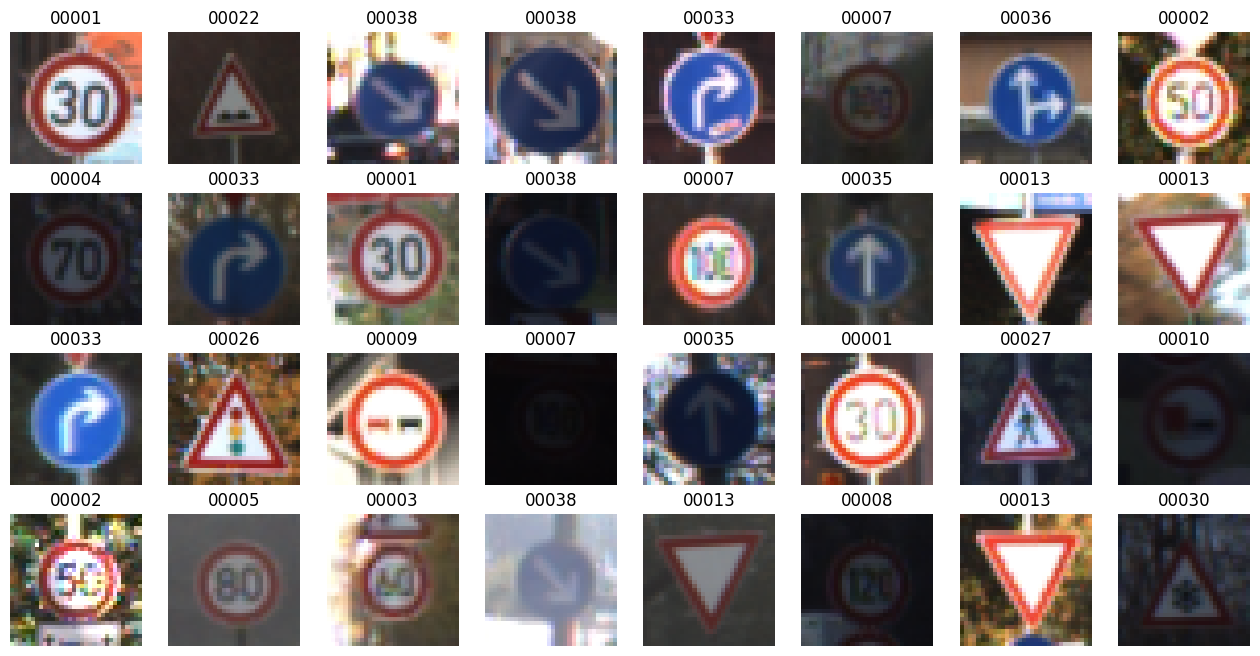

<Figure size 640x480 with 0 Axes>

In [49]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

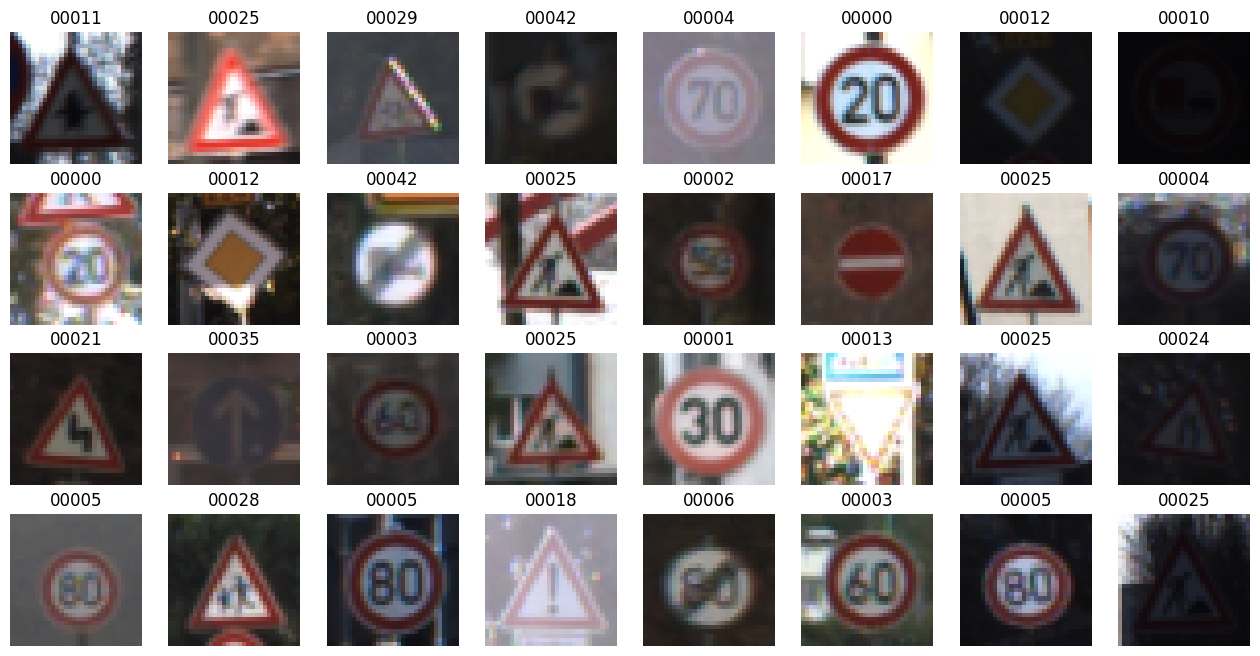

<Figure size 640x480 with 0 Axes>

In [50]:
images, targets = next(iter(val_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

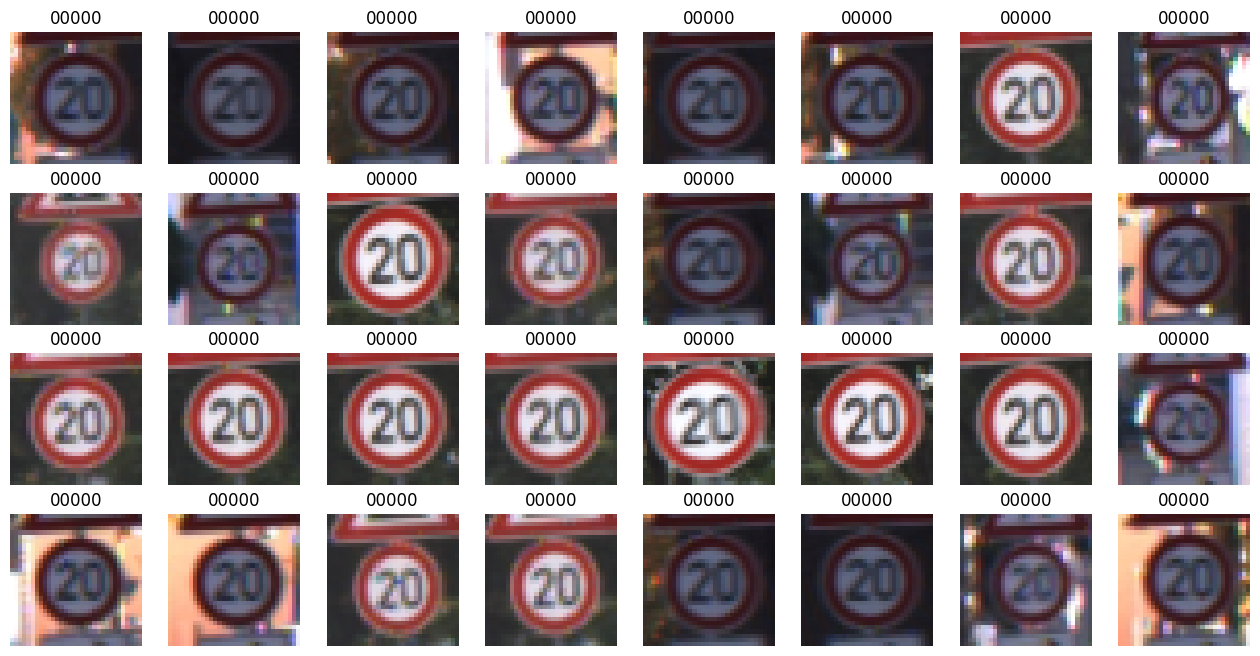

<Figure size 640x480 with 0 Axes>

In [51]:
images, targets = next(iter(test_loader))
vcpi_util.show_images(4,8,images,targets,test_set.classes)

In [52]:
model_I = Conv(len(rtrain_set.classes))
model_I.to(device)

optimizer = torch.optim.Adam(model_I.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9)

print(torchinfo.summary(model_I, input_size=(BATCH_SIZE,3,IMG_SIZE,IMG_SIZE)))

Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     [64, 43]                  --
├─Conv2d: 1-1                            [64, 16, 30, 30]          448
├─BatchNorm2d: 1-2                       [64, 16, 30, 30]          32
├─ReLU: 1-3                              [64, 16, 30, 30]          --
├─Conv2d: 1-4                            [64, 32, 28, 28]          4,640
├─BatchNorm2d: 1-5                       [64, 32, 28, 28]          64
├─ReLU: 1-6                              [64, 32, 28, 28]          --
├─MaxPool2d: 1-7                         [64, 32, 14, 14]          --
├─Conv2d: 1-8                            [64, 48, 12, 12]          13,872
├─BatchNorm2d: 1-9                       [64, 48, 12, 12]          96
├─ReLU: 1-10                             [64, 48, 12, 12]          --
├─Conv2d: 1-11                           [64, 48, 10, 10]          20,784
├─BatchNorm2d: 1-12                      [64, 48, 10, 10]          96
├─R

In [11]:
history_I = train2(
    model_I, train_loader, val_loader,
    EPOCHS, loss_fn, optimizer, scheduler, early_stop, 'model_I_base')

Epoch: 000; Loss: 0.007176; Accuracy: 89.0188; Val Loss: 0.000891; Val Acc: 98.8352; Elapsed time: 39.5944
Epoch: 001; Loss: 0.000511; Accuracy: 99.4025; Val Loss: 0.000515; Val Acc: 99.2348; Elapsed time: 39.4007
Epoch: 002; Loss: 0.000160; Accuracy: 99.8543; Val Loss: 0.000259; Val Acc: 99.6259; Elapsed time: 40.8961
Epoch: 003; Loss: 0.000050; Accuracy: 99.9818; Val Loss: 0.000197; Val Acc: 99.7534; Elapsed time: 41.2938
Epoch: 004; Loss: 0.000018; Accuracy: 100.0000; Val Loss: 0.000182; Val Acc: 99.7534; Elapsed time: 42.0294
Epoch: 005; Loss: 0.000009; Accuracy: 100.0000; Val Loss: 0.000169; Val Acc: 99.7534; Elapsed time: 41.7544
Epoch: 006; Loss: 0.000006; Accuracy: 100.0000; Val Loss: 0.000163; Val Acc: 99.7789; Elapsed time: 42.1475
Epoch: 007; Loss: 0.000004; Accuracy: 100.0000; Val Loss: 0.000159; Val Acc: 99.7789; Elapsed time: 43.7837
Epoch: 008; Loss: 0.000003; Accuracy: 100.0000; Val Loss: 0.000157; Val Acc: 99.7875; Elapsed time: 42.3980
Epoch: 009; Loss: 0.000002; Accu

In [12]:
evaluate(model_I, test_loader)

0.9795724749565125

---

In [14]:
from torchvision.transforms import v2


transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.2,p=1.0),
        v2.RandomAffine(degrees=3, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
        v2.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2),
        v2.RandomEqualize(p=0.5),
])


base_transform = v2.Compose([
        v2.ToImage(),
        v2.Resize((IMG_SIZE, IMG_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
])

class TransfDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)
  

In [15]:
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
train_set, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3])

train_loader = torch.utils.data.DataLoader(TransfDataset(train_set,transform), batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(TransfDataset(val_set,base_transform), batch_size = BATCH_SIZE)

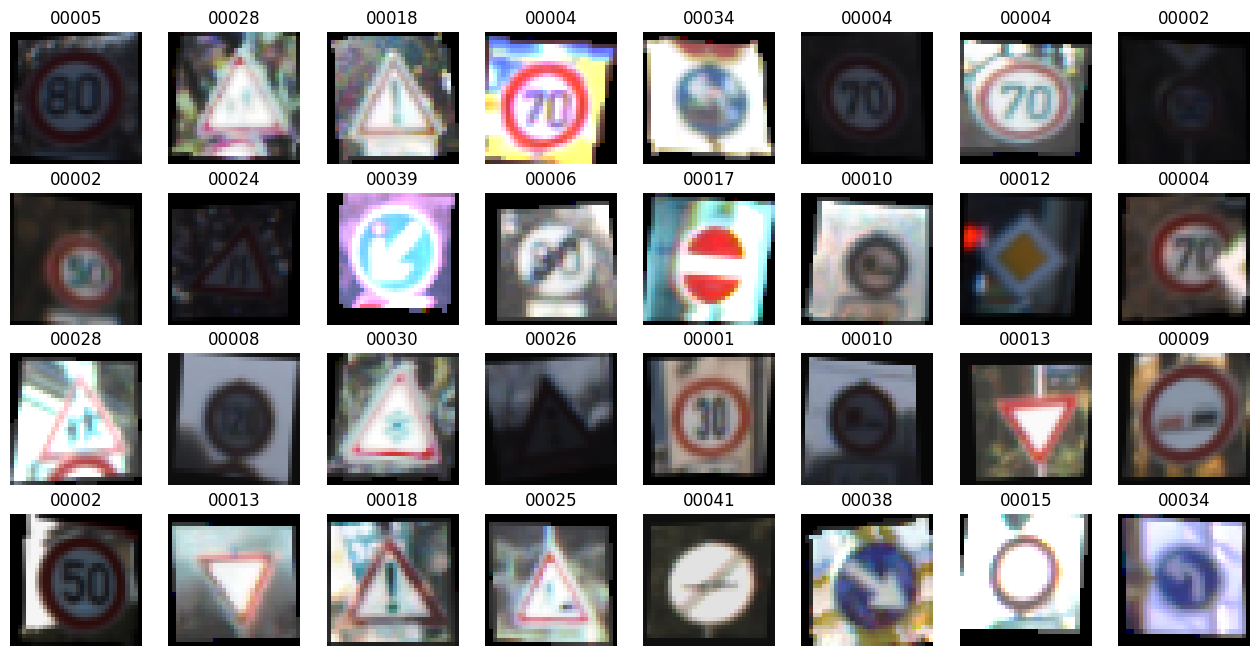

<Figure size 640x480 with 0 Axes>

In [16]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

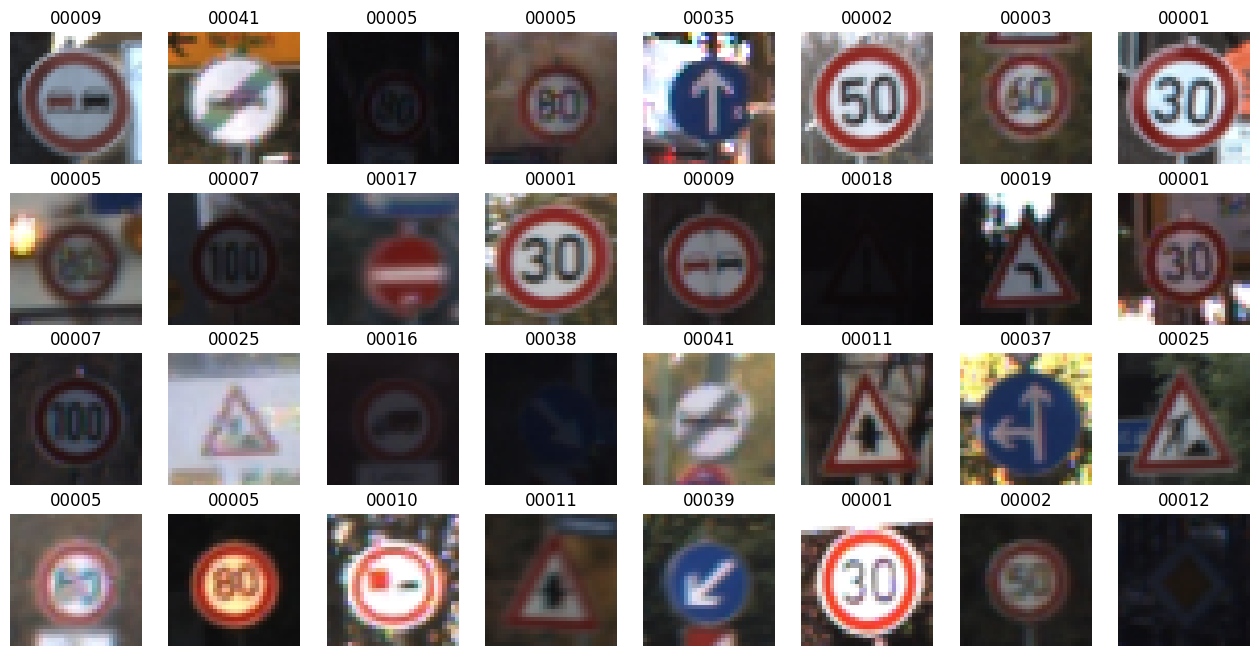

<Figure size 640x480 with 0 Axes>

In [17]:
images, targets = next(iter(val_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

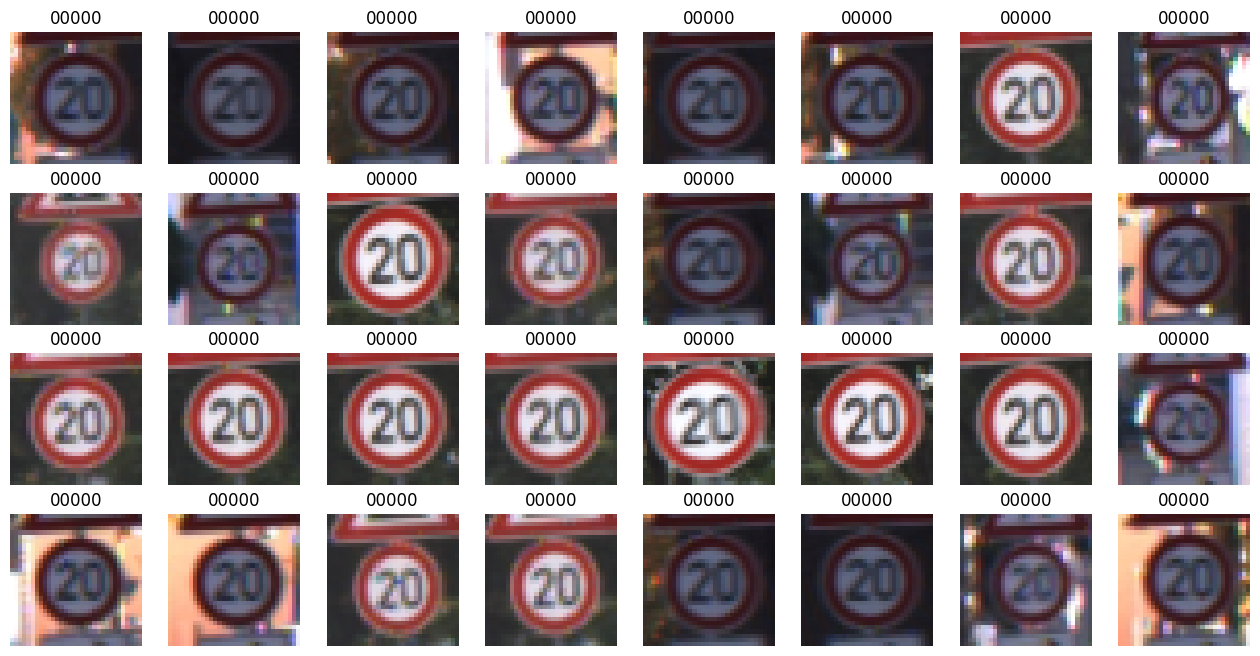

<Figure size 640x480 with 0 Axes>

In [18]:
images, targets = next(iter(test_loader))
vcpi_util.show_images(4,8,images,targets,test_set.classes)

In [19]:
import os
class Conv(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)


        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(1200, num_classes)
        

    def forward(self, x):    
        
        # input = (bs, 3, 32, 32)
        x = self.conv1(x) # -> (bs, 16, 30, 30)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x) # -> (bs, 32, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool1(x) # -> (bs, 32, 14, 14)
        
        x = self.conv3(x) # -> (bs, 48, 12, 12)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x) # -> (bs, 48, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool2(x) # -> (bs, 48, 5, 5)
        
        x = torch.flatten(x,1) # -> (bs, 48 * 5 * 5 = 1200)
        x = self.fc1(x)        # -> (bs, num_classes)

        return(x)



class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):

        self.patience = patience 
        self.min_delta = min_delta

        self.min_delta
        self.min_val_loss = float('inf')

    def __call__(self, val_loss):

        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False
    


model_I = Conv(len(rtrain_set.classes))
model_I.to(device)

optimizer = torch.optim.Adam(model_I.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9)

In [20]:
history_I = train2(
    model_I, train_loader, val_loader,
    EPOCHS, loss_fn, optimizer, scheduler, early_stop, 'model_I_transforms')

Epoch: 000; Loss: 0.015854; Accuracy: 71.8330; Val Loss: 0.001765; Val Acc: 97.7895; Elapsed time: 56.5083
Epoch: 001; Loss: 0.003633; Accuracy: 93.6204; Val Loss: 0.001054; Val Acc: 98.5292; Elapsed time: 58.6189
Epoch: 002; Loss: 0.002175; Accuracy: 96.0469; Val Loss: 0.000466; Val Acc: 99.2943; Elapsed time: 61.1273
Epoch: 003; Loss: 0.001640; Accuracy: 97.0525; Val Loss: 0.000480; Val Acc: 99.3624; Elapsed time: 61.1337
Epoch: 004; Loss: 0.001381; Accuracy: 97.3476; Val Loss: 0.000446; Val Acc: 99.3539; Elapsed time: 61.9110
Epoch: 005; Loss: 0.001150; Accuracy: 97.9415; Val Loss: 0.000315; Val Acc: 99.5749; Elapsed time: 61.4163
Epoch: 006; Loss: 0.000999; Accuracy: 98.0216; Val Loss: 0.000241; Val Acc: 99.6004; Elapsed time: 66.6718
Epoch: 007; Loss: 0.001012; Accuracy: 97.9998; Val Loss: 0.000575; Val Acc: 98.9032; Elapsed time: 63.8732
Epoch: 008; Loss: 0.000902; Accuracy: 98.2293; Val Loss: 0.000202; Val Acc: 99.7279; Elapsed time: 62.6970
Epoch: 009; Loss: 0.000823; Accuracy:

In [21]:
evaluate(model_I, test_loader)

0.9882818460464478

---

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedConv(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedConv, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # -> (bs, 32, 16, 16)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # -> (bs, 64, 8, 8)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # -> (bs, 128, 4, 4)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # -> (bs, 256, 2, 2)
        
        x = torch.flatten(x, 1)  # -> (bs, 256 * 2 * 2)
        
        x = F.relu(self.fc1(x))  # -> (bs, 512)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))  # -> (bs, 256)
        x = self.dropout(x)
        x = self.fc3(x)          # -> (bs, num_classes)
        
        return x

In [19]:
from torchvision.transforms import v2


transform = v2.Compose([
        v2.RandomPerspective(distortion_scale=0.2,p=1.0),
        v2.RandomAffine(degrees=3, translate=(0.03,0.03)),
        v2.RandomRotation(3, v2.InterpolationMode.BILINEAR),
        v2.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2),
        v2.RandomEqualize(p=0.5),
        v2.RandomErasing(p=1, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random')
])


base_transform = v2.Compose([
        v2.ToImage(),
        v2.Resize((IMG_SIZE, IMG_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
])

class TransfDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)
  

In [20]:
test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = base_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

rtrain_set = torchvision.datasets.ImageFolder(root=PATH_TRAINING_SET, transform = base_transform)
train_set, val_set = torch.utils.data.random_split(rtrain_set, [0.7,0.3])

train_loader = torch.utils.data.DataLoader(TransfDataset(train_set,transform), batch_size = BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(TransfDataset(val_set,base_transform), batch_size = BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

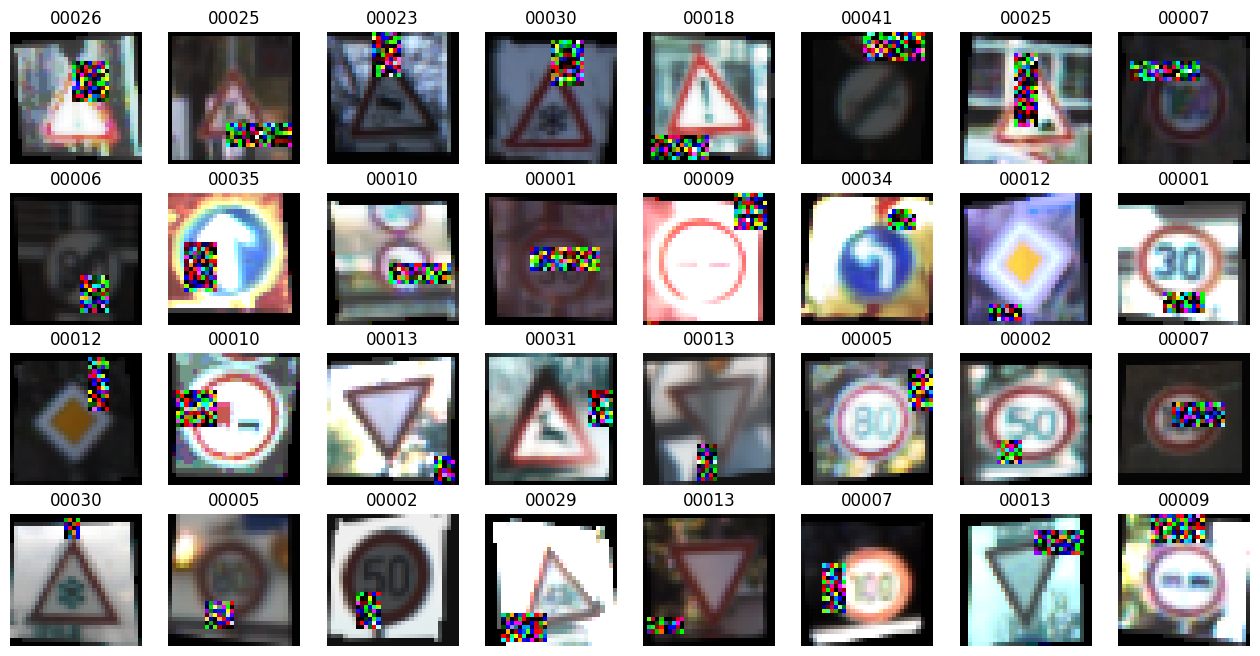

<Figure size 640x480 with 0 Axes>

In [21]:
images, targets = next(iter(train_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

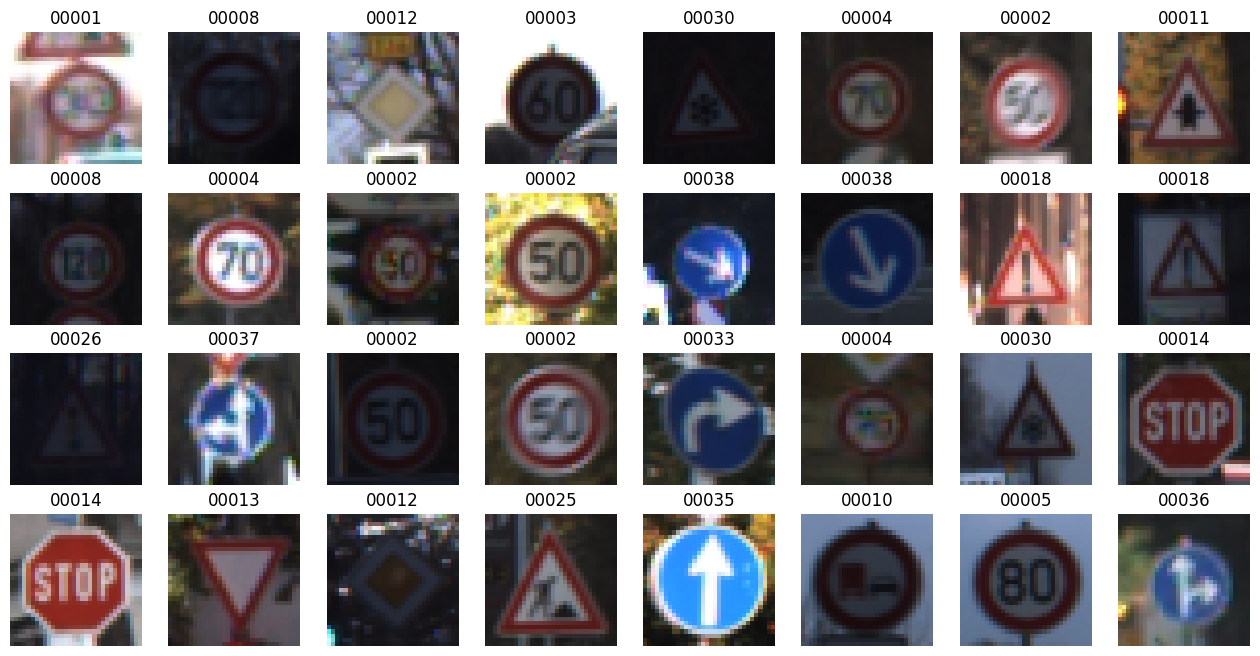

<Figure size 640x480 with 0 Axes>

In [22]:
images, targets = next(iter(val_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

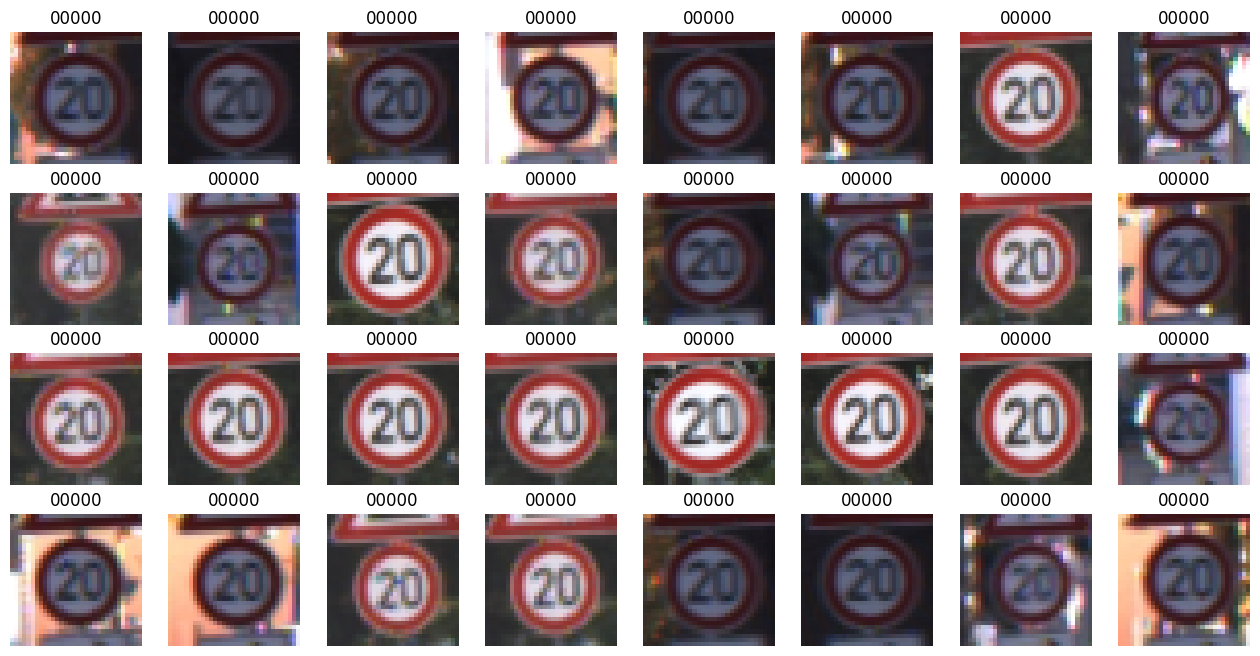

<Figure size 640x480 with 0 Axes>

In [23]:
images, targets = next(iter(test_loader))
vcpi_util.show_images(4,8,images,targets,test_set.classes)

In [39]:
model_I = EnhancedConv(len(rtrain_set.classes))
model_I.to(device)

optimizer = torch.optim.Adam(model_I.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9)


NameError: name 'EnhancedConv' is not defined

In [27]:
history_I = train2(
    model_I, train_loader, val_loader,
    EPOCHS, loss_fn, optimizer, scheduler, early_stop, 'model14_ConvEn')

Epoch: 000; Loss: 0.051763; Accuracy: 9.1850; Val Loss: 0.037786; Val Acc: 24.0180; Elapsed time: 73.3953
Epoch: 001; Loss: 0.035116; Accuracy: 28.3710; Val Loss: 0.026628; Val Acc: 39.6446; Elapsed time: 77.4498
Epoch: 002; Loss: 0.029974; Accuracy: 35.2425; Val Loss: 0.023856; Val Acc: 43.2409; Elapsed time: 78.4995
Epoch: 003; Loss: 0.027819; Accuracy: 38.5397; Val Loss: 0.021250; Val Acc: 49.1583; Elapsed time: 78.5618
Epoch: 004; Loss: 0.026207; Accuracy: 41.8151; Val Loss: 0.018807; Val Acc: 53.6388; Elapsed time: 78.9798
Epoch: 005; Loss: 0.024487; Accuracy: 45.0760; Val Loss: 0.016545; Val Acc: 61.6137; Elapsed time: 79.5127
Epoch: 006; Loss: 0.023064; Accuracy: 48.0854; Val Loss: 0.015648; Val Acc: 67.3610; Elapsed time: 80.9350
Epoch: 007; Loss: 0.021602; Accuracy: 51.4337; Val Loss: 0.014211; Val Acc: 68.5853; Elapsed time: 80.7329
Epoch: 008; Loss: 0.020577; Accuracy: 53.6598; Val Loss: 0.012721; Val Acc: 74.8512; Elapsed time: 80.2377
Epoch: 009; Loss: 0.019840; Accuracy: 

In [28]:
evaluate(model_I, test_loader)

0.9828978776931763

---

Transfer Learning

---

In [22]:
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


In [24]:
modelImagenet = torchvision.models.vgg16(weights = torchvision.models.VGG16_Weights.IMAGENET1K_V1)
#Vamos utilizar a mobilenet que é uma rede mais simples/rápida para uma possível utilização em carros por exemplo
modelMobileNet = torchvision.models.mobilenet_v2(weights = torchvision.models.MobileNet_V2_Weights.IMAGENET1K_V2)
modelEficientNet = torchvision.models.efficientnet_b0(weights = torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /Users/rkeat/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 21.3MB/s]


In [26]:
print(modelImagenet.to(device))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [29]:
print(torchinfo.summary(modelImagenet, input_size=(1, 3, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 1, 1]            --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─ReLU: 2-2                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 64, 32, 32]           36,928
│    └─ReLU: 2-4                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-5                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 128, 16, 16]          73,856
│    └─ReLU: 2-7                         [1, 128, 16, 16]          --
│    └─Conv2d: 2-8                       [1, 128, 16, 16]          147,584
│    └─ReLU: 2-9                         [1, 128, 16, 16]          --
│    └─MaxPool2d: 2-10                   [1, 128, 8, 8]            --
│    └─Conv2d: 2-11                      [1, 256, 8, 8]            29

In [27]:
print(modelMobileNet.to(device))

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [30]:
print(torchinfo.summary(modelMobileNet, input_size=(1, 3, 32, 32)))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [1, 1000]                 --
├─Sequential: 1-1                                  [1, 1280, 1, 1]           --
│    └─Conv2dNormActivation: 2-1                   [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-1                            [1, 32, 16, 16]           864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 16, 16]           64
│    │    └─ReLU6: 3-3                             [1, 32, 16, 16]           --
│    └─InvertedResidual: 2-2                       [1, 16, 16, 16]           --
│    │    └─Sequential: 3-4                        [1, 16, 16, 16]           896
│    └─InvertedResidual: 2-3                       [1, 24, 8, 8]             --
│    │    └─Sequential: 3-5                        [1, 24, 8, 8]             5,136
│    └─InvertedResidual: 2-4                       [1, 24, 8, 8]             --
│    │    └─Sequential: 3-6   

In [28]:
print(modelEficientNet.to(device))

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [31]:
print(torchinfo.summary(modelMobileNet, input_size=(1, 3, 32, 32)))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [1, 1000]                 --
├─Sequential: 1-1                                  [1, 1280, 1, 1]           --
│    └─Conv2dNormActivation: 2-1                   [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-1                            [1, 32, 16, 16]           864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 16, 16]           64
│    │    └─ReLU6: 3-3                             [1, 32, 16, 16]           --
│    └─InvertedResidual: 2-2                       [1, 16, 16, 16]           --
│    │    └─Sequential: 3-4                        [1, 16, 16, 16]           896
│    └─InvertedResidual: 2-3                       [1, 24, 8, 8]             --
│    │    └─Sequential: 3-5                        [1, 24, 8, 8]             5,136
│    └─InvertedResidual: 2-4                       [1, 24, 8, 8]             --
│    │    └─Sequential: 3-6   

In [53]:
# Freeze all layers
for param in modelMobileNet.parameters():
    param.requires_grad = False

print()

n_inputs = modelMobileNet.classifier[1].in_features

modelMobileNet.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(n_inputs, 43),
)
modelMobileNet.to(device)
print(modelMobileNet)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps

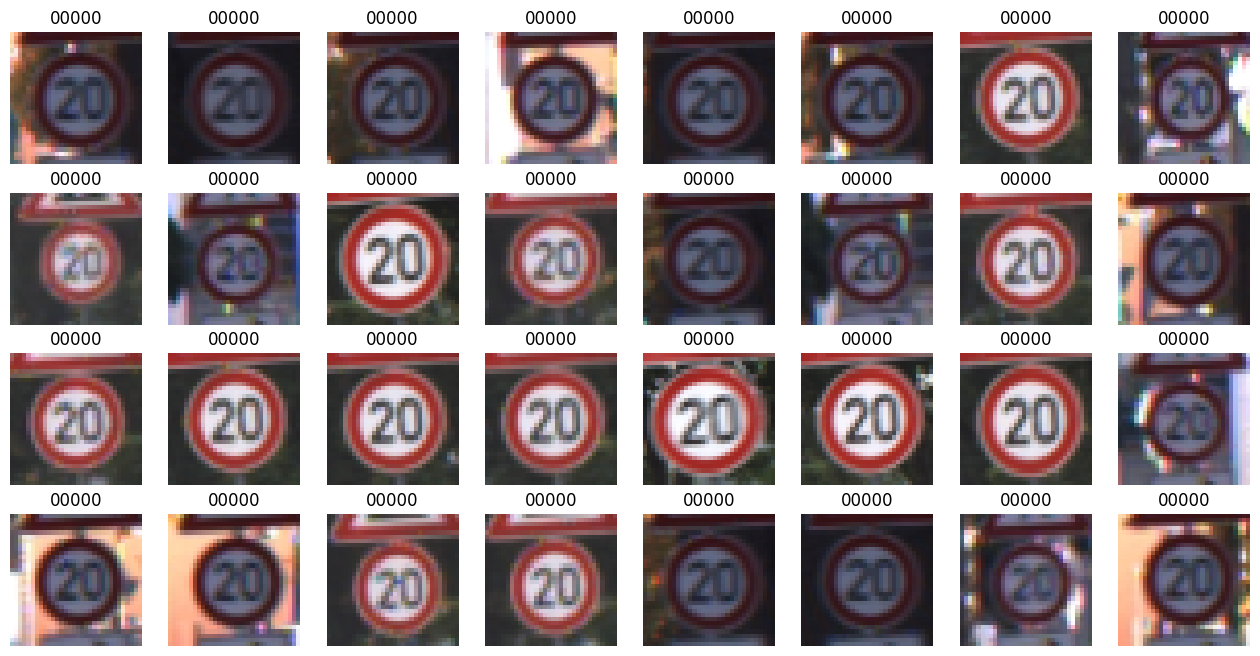

<Figure size 640x480 with 0 Axes>

In [54]:
#vamos ver imagens no dataset de teste
images, targets = next(iter(test_loader))
vcpi_util.show_images(4,8,images,targets,test_set.classes)

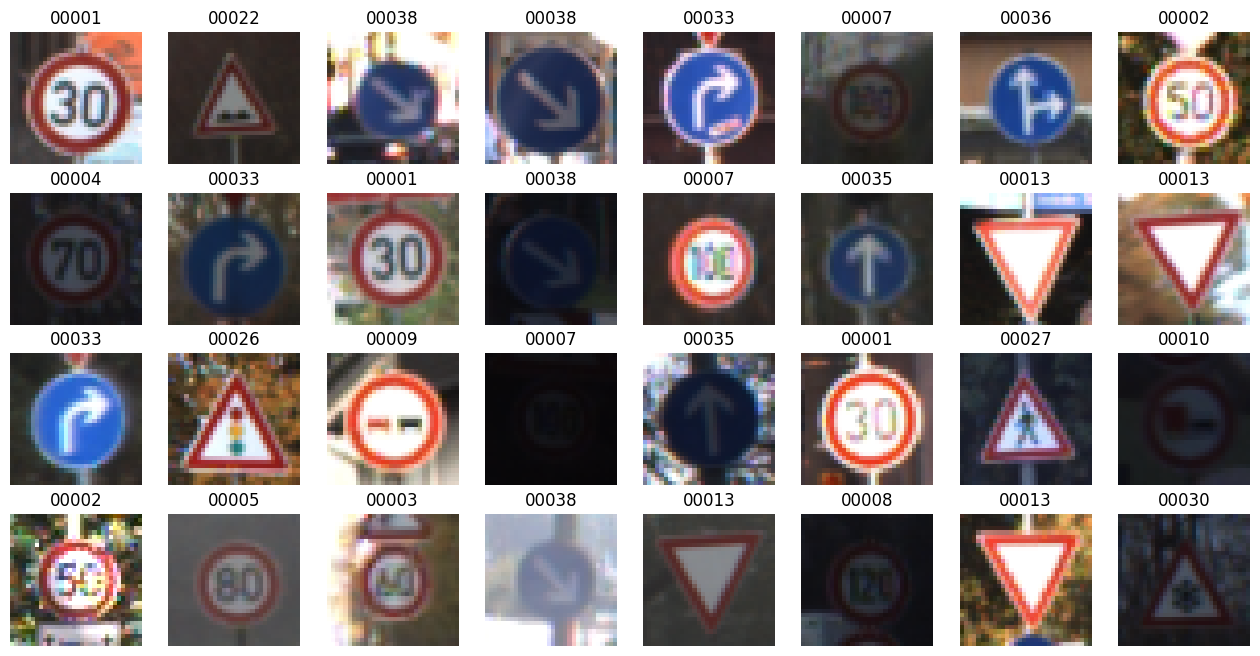

<Figure size 640x480 with 0 Axes>

In [55]:
images, targets = next(iter(train_loader))

vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

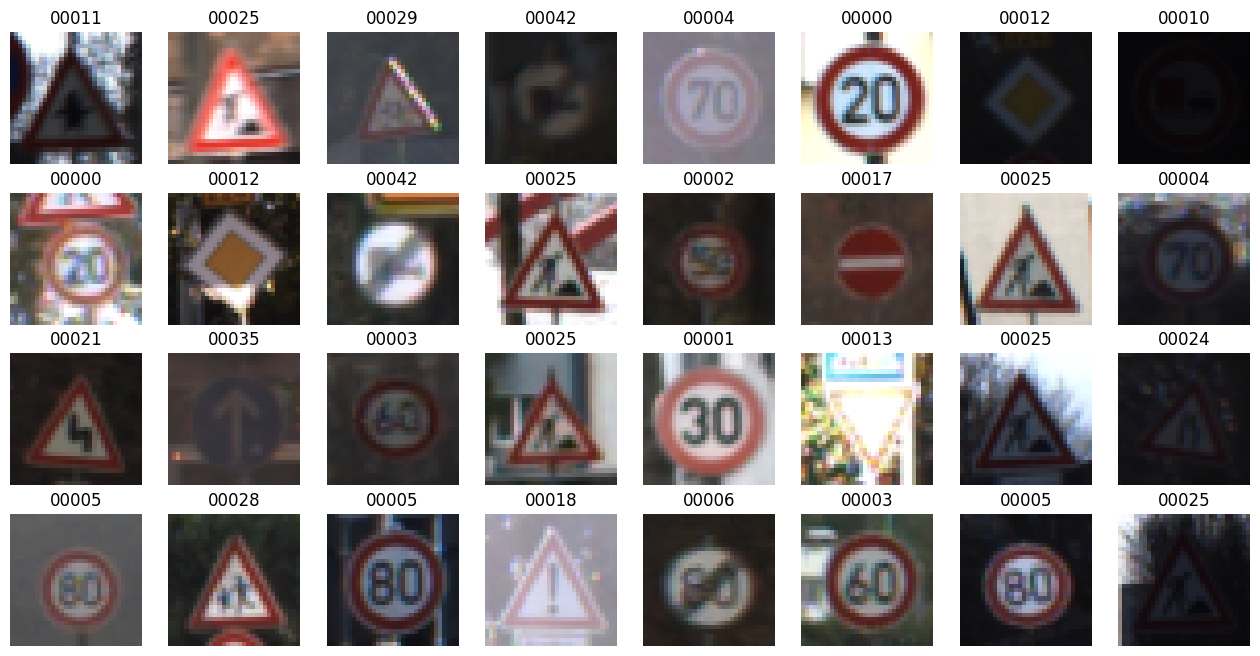

<Figure size 640x480 with 0 Axes>

In [56]:
images, targets = next(iter(val_loader))
vcpi_util.show_images(4,8,images,targets,rtrain_set.classes)

In [57]:
optimizer = torch.optim.Adam(modelMobileNet.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor = 0.1, patience=3)
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(9)

In [59]:
history_I = train2(
    modelMobileNet, train_loader, val_loader,
    EPOCHS, loss_fn, optimizer, scheduler, early_stop, 'modelMobileNet')

Epoch: 000; Loss: 0.033234; Accuracy: 41.8625; Val Loss: 0.033698; Val Acc: 41.2175; Elapsed time: 280.3152
Epoch: 001; Loss: 0.030688; Accuracy: 45.4330; Val Loss: 0.033000; Val Acc: 41.9742; Elapsed time: 295.0239
Epoch: 002; Loss: 0.029114; Accuracy: 46.9304; Val Loss: 0.032763; Val Acc: 41.8806; Elapsed time: 298.8658
Epoch: 003; Loss: 0.028130; Accuracy: 47.9142; Val Loss: 0.032686; Val Acc: 42.4588; Elapsed time: 309.8345
Epoch: 004; Loss: 0.027291; Accuracy: 49.6302; Val Loss: 0.032870; Val Acc: 42.3397; Elapsed time: 329.1561
Epoch: 005; Loss: 0.026781; Accuracy: 49.6994; Val Loss: 0.032953; Val Acc: 42.1442; Elapsed time: 338.5935


KeyboardInterrupt: 